In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from math import floor
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available")

GPU available


In [3]:
# Loading MNIST dataset from torchvision.dataset
dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

print("The shape of the dataset is :", dataset.data.size())

The shape of the dataset is : torch.Size([60000, 28, 28])


In [4]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [50_000, 10_000])

In [5]:
class CustomModel(nn.Module):
    
    def __init__(self, layers=['dense_512'], with_softmax=True, hidden_activation=torch.relu):
        super().__init__()
        assert isinstance(layers, list)
        for layer in layers: assert isinstance(layer, str) 
        self.with_softmax = with_softmax
        self.hidden_activation = hidden_activation
        self.n_hidden_layers = len(layers)
        self.input_shapes = None
        self.needs_input_flat = True
        
        for i, layer in enumerate(layers):
            params = layer.split('_')
            layer_type, params = params[0], params[1:]
            assert layer_type in ['dense', 'conv2d', 'maxpool2d', 'flatten']
            
            
            if layer_type == 'dense':
                if i == 0:
                    self.needs_input_flat = True
                    self.input_shapes = [28*28]
                n_neurons = int(params[0])
                in_shape = self.input_shapes[-1]
                layer = nn.Linear(in_shape, n_neurons)
                self.input_shapes.append(n_neurons)
            
            elif layer_type == 'conv2d':
                if i == 0:
                    self.needs_input_flat = False
                    self.input_shapes = [(28,28,1)]
                in_shape = self.input_shapes[-1]
                assert isinstance(in_shape, tuple)
                assert len(in_shape) == 3
                in_width, in_height, in_channels = in_shape
                n_channels, kernel_size, stride = int(params[0]), int(params[1]), int(params[2])
                layer = nn.Conv2d(in_channels=in_channels,
                                  out_channels=n_channels, 
                                  kernel_size=kernel_size, 
                                  stride=stride)
                self.input_shapes.append(
                    (floor((in_width - kernel_size)/stride + 1),
                     floor((in_height - kernel_size)/stride + 1),
                     n_channels
                    )
                )
            elif layer_type == 'flatten':
                layer = nn.Flatten()
                in_shape = self.input_shapes[-1]
                out_shape = in_shape[0]*in_shape[1]*in_shape[2]
                self.input_shapes.append(out_shape)
            
            elif layer_type == 'maxpool2d':
                in_shape = self.input_shapes[-1]
                assert isinstance(in_shape, tuple)
                assert len(in_shape) == 3
                in_width, in_height, _ = in_shape
                
                kernel_size = int(params[0])
                layer = nn.MaxPool2d(kernel_size=kernel_size)
                self.input_shapes.append(
                        (floor((in_width - kernel_size)/kernel_size + 1),
                         floor((in_height - kernel_size)/kernel_size + 1),
                         n_channels
                        )
                    )

            setattr(self, 'hidden_{}'.format(i), layer)
            
        self.output = nn.Linear(self.input_shapes[-1], 10)
    
    def forward(self, x):
        for i in range(self.n_hidden_layers):
            layer = getattr(self, "hidden_{}".format(i))
            x = self.hidden_activation(layer(x))
        x = self.output(x)
        if self.with_softmax:
            x = F.softmax(x, dim=1)
        return x

In [6]:
def compute_accuracy(model, val_set, gpu=None):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(val_set, batch_size=100, pin_memory=True, num_workers=6)
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            if model.needs_input_flat:
                images = images.view(-1, 28*28)
            else:
                images = images.view(-1, 1, 28, 28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum()
    return correct.item()/ len(val_set)

In [7]:
def train(model, optimizer, criterion, epochs, batch_size, verbose=1):
    model.to(device)
    print("Training started - {} epochs; batch size: {}; learning rate: {}"
          .format(epochs, batch_size, optimizer.defaults["lr"]))
    train_error = []
    train_loader = DataLoader(train_set, batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=6)
    model.train()
    for epoch in range(epochs):
        epoch_average_loss = 0.0
        if verbose > 1: train_loader = tqdm(train_loader)
        for (images, labels) in train_loader:
            images, labels = images.to(device), labels.to(device)
            if model.needs_input_flat:
                y_pre = model(images.view(batch_size, -1)) 
            else:
                y_pre = model(images.view(batch_size, 1, 28, 28))
            
            # One-hot encoding or labels so as to calculate MSE error:
            if model.with_softmax:
                labels = labels.view(-1, 1)
                labels_one_hot = torch.FloatTensor(batch_size, 10).to(device)
                labels_one_hot.zero_()
                labels_one_hot.scatter_(1, labels, 1)
                loss = criterion(y_pre, labels_one_hot)
            else:
                loss = criterion(y_pre, labels)
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(train_set)
        train_error.append(epoch_average_loss)
        if verbose > 0: print('Epoch [{}/{}], Loss: {:.4f}'
                              .format(epoch+1, epochs, epoch_average_loss))
    return train_error

In [8]:
def plot_convergence(model_name, train_error, val_acc):
    plt.plot(range(1, len(train_error) + 1), train_error)
    plt.title("Train error for {} - Validation accuracy: {:.2f}%".format(model_name, val_acc*100))
    plt.xticks(range(1, len(train_error) + 1))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    
    
def plot_image(model, val_set, val_index=66):
    (image, label) = val_set[val_index]
    image = image.to(device)
    if model.needs_input_flat:
        image = image.view(-1, 28*28)
    else:
        image = image.view(-1, 1, 28, 28)
    output = model(image)
    _, prediction = torch.max(output.data, 1)
    plt.imshow(image.cpu().view(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Prediction label: %d" % prediction)


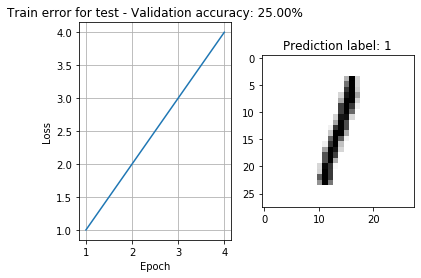

In [65]:
plt.subplot(121)
plot_convergence("test", [1, 2, 3, 4], 0.25)
plt.subplot(122)
plot_image(model=model, val_set=val_set)
plt.show()

## Impact of the architecture

### Depth influence

Training model:  1 layer, 50 neurons
Training started - 8 epochs; batch size: 100; learning rate: 0.05



Epoch [1/8], Loss: 0.0894



Epoch [2/8], Loss: 0.0869



Epoch [3/8], Loss: 0.0823



Epoch [4/8], Loss: 0.0760



Epoch [5/8], Loss: 0.0674



Epoch [6/8], Loss: 0.0577



Epoch [7/8], Loss: 0.0489



Epoch [8/8], Loss: 0.0414


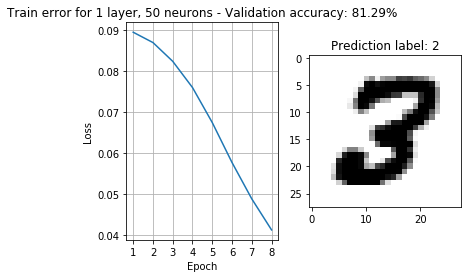

--------------------
Training model:  3 layers, 50 neurons
Training started - 8 epochs; batch size: 100; learning rate: 0.1



Epoch [1/8], Loss: 0.0900



Epoch [2/8], Loss: 0.0899



Epoch [3/8], Loss: 0.0898



Epoch [4/8], Loss: 0.0896



Epoch [5/8], Loss: 0.0893



Epoch [6/8], Loss: 0.0890



Epoch [7/8], Loss: 0.0884



Epoch [8/8], Loss: 0.0874


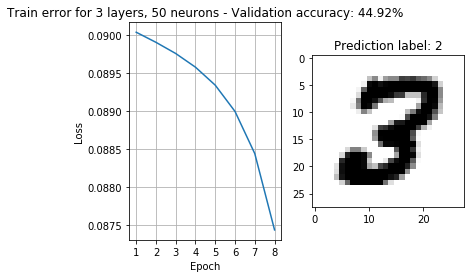

--------------------
Training model:  5 layers, 50 neurons
Training started - 8 epochs; batch size: 100; learning rate: 0.1



Epoch [1/8], Loss: 0.0901



Epoch [2/8], Loss: 0.0900



Epoch [3/8], Loss: 0.0900



Epoch [4/8], Loss: 0.0900



Epoch [5/8], Loss: 0.0900



Epoch [6/8], Loss: 0.0900



Epoch [7/8], Loss: 0.0900



Epoch [8/8], Loss: 0.0900


Exception ignored in: <bound method _ConnectionBase.__del__ of <multiprocessing.connection.PipeConnection object at 0x000001945422B0B8>>
Traceback (most recent call last):
  File "C:\Users\sbran\Anaconda3\envs\adl\lib\multiprocessing\connection.py", line 132, in __del__
    self._close()
  File "C:\Users\sbran\Anaconda3\envs\adl\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] Descripteur non valide


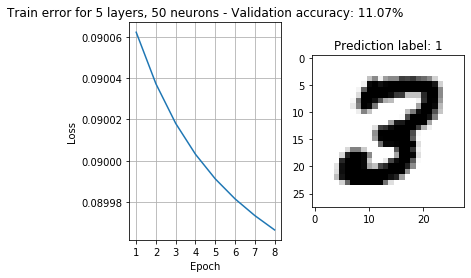

--------------------


In [95]:
epochs = 8
batch_size = 100

architectures = {
    "1 layer, 50 neurons": (["dense_50"]*1, 0.05),
    "3 layers, 50 neurons": (["dense_50"]*3, 0.1),
    "5 layers, 50 neurons": (["dense_50"]*5, 0.5)
}

results = {}

for name, (arch, lr) in architectures.items():
    model = CustomModel(layers=arch, with_softmax=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss = nn.MSELoss()
    print("Training model: ", name)
    train_errors = train(model, optimizer, loss, epochs, batch_size, verbose=1)
    val_acc = compute_accuracy(model, val_set)
    plt.subplot(121)
    plot_convergence(model_name=name, train_error=train_errors, val_acc=val_acc)
    plt.subplot(122)
    plot_image(model=model, val_set=val_set)
    plt.show()
    print("-"*20)

### Width influence

Training model:  3 layer, 50 neurons
Training started - 8 epochs; batch size: 100; learning rate: 0.1
Epoch [1/8], Loss: 0.0900
Epoch [2/8], Loss: 0.0899
Epoch [3/8], Loss: 0.0898
Epoch [4/8], Loss: 0.0896
Epoch [5/8], Loss: 0.0894
Epoch [6/8], Loss: 0.0890
Epoch [7/8], Loss: 0.0884
Epoch [8/8], Loss: 0.0872


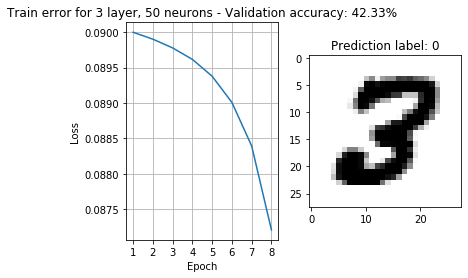

--------------------
Training model:  3 layers, 100 neurons
Training started - 8 epochs; batch size: 100; learning rate: 0.1
Epoch [1/8], Loss: 0.0900
Epoch [2/8], Loss: 0.0898
Epoch [3/8], Loss: 0.0897
Epoch [4/8], Loss: 0.0895
Epoch [5/8], Loss: 0.0891
Epoch [6/8], Loss: 0.0885
Epoch [7/8], Loss: 0.0874
Epoch [8/8], Loss: 0.0841


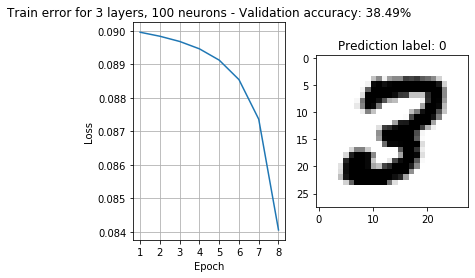

--------------------
Training model:  3 layers, 300 neurons
Training started - 8 epochs; batch size: 100; learning rate: 0.1
Epoch [1/8], Loss: 0.0899
Epoch [2/8], Loss: 0.0898
Epoch [3/8], Loss: 0.0896
Epoch [4/8], Loss: 0.0893
Epoch [5/8], Loss: 0.0888
Epoch [6/8], Loss: 0.0879
Epoch [7/8], Loss: 0.0855
Epoch [8/8], Loss: 0.0786


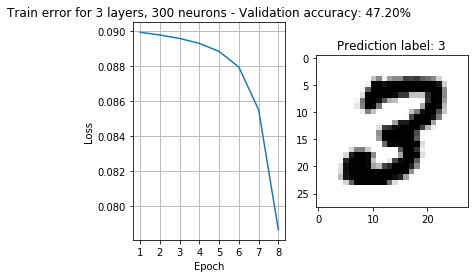

--------------------


In [97]:
epochs = 8
batch_size = 100
lr = 0.1

architectures = {
    "3 layer, 50 neurons": ["dense_50"]*3,
    "3 layers, 100 neurons": ["dense_100"]*3,
    "3 layers, 300 neurons": ["dense_300"]*3,
}

results = {}

for name, arch in architectures.items():
    model = CustomModel(layers=arch, with_softmax=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss = nn.MSELoss()
    print("Training model: ", name)
    train_errors = train(model, optimizer, loss, epochs, batch_size, verbose=1)
    val_acc = compute_accuracy(model, val_set)
    plt.subplot(121)
    plot_convergence(model_name=name, train_error=train_errors, val_acc=val_acc)
    plt.subplot(122)
    plot_image(model=model, val_set=val_set)
    plt.show()
    print("-"*20)

### Influence of Convolutional layers

All Convolutional features are followed by a 300 neurons Linear Layer
Convolutional block: 2 Convolutional layers with 32 filters (kernel size 3), followed by a MaxPool2d layer
Training model:  no conv. block
Training started - 8 epochs; batch size: 100; learning rate: 0.05
Epoch [1/8], Loss: 0.0890
Epoch [2/8], Loss: 0.0861
Epoch [3/8], Loss: 0.0809
Epoch [4/8], Loss: 0.0728
Epoch [5/8], Loss: 0.0621
Epoch [6/8], Loss: 0.0513
Epoch [7/8], Loss: 0.0428
Epoch [8/8], Loss: 0.0365


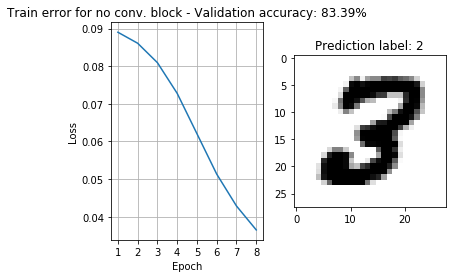

--------------------
Training model:  1 conv. block
Training started - 8 epochs; batch size: 100; learning rate: 0.05
Epoch [1/8], Loss: 0.0899
Epoch [2/8], Loss: 0.0896
Epoch [3/8], Loss: 0.0890
Epoch [4/8], Loss: 0.0876
Epoch [5/8], Loss: 0.0794
Epoch [6/8], Loss: 0.0396
Epoch [7/8], Loss: 0.0211
Epoch [8/8], Loss: 0.0174


Exception ignored in: <bound method _ConnectionBase.__del__ of <multiprocessing.connection.PipeConnection object at 0x00000194662DB160>>
Traceback (most recent call last):
  File "C:\Users\sbran\Anaconda3\envs\adl\lib\multiprocessing\connection.py", line 132, in __del__
    self._close()
  File "C:\Users\sbran\Anaconda3\envs\adl\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] Descripteur non valide


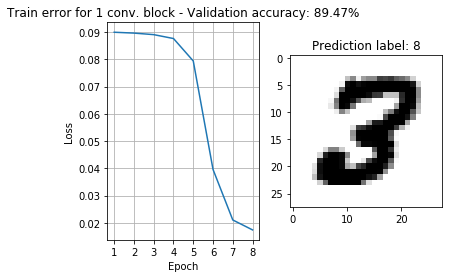

--------------------


In [101]:
print("All Convolutional features are followed by a 300 neurons Linear Layer")
print("Convolutional block: 2 Convolutional layers with 32 filters (kernel size 3), followed by a MaxPool2d layer")
print("-"*20)

epochs = 8
batch_size = 100
lr = 0.05

architectures = {
    "no conv. block": ["dense_300"]*1,
    "1 conv. block": ["conv2d_32_3_1", "conv2d_32_3_1", "maxpool2d_3"]*1 + ["flatten"] + ["dense_300"]*1,
}

results = {}

for name, arch in architectures.items():
    model = CustomModel(layers=arch, with_softmax=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss = nn.MSELoss()
    print("Training model: ", name)
    train_errors = train(model, optimizer, loss, epochs, batch_size, verbose=1)
    val_acc = compute_accuracy(model, val_set)
    plt.subplot(121)
    plot_convergence(model_name=name, train_error=train_errors, val_acc=val_acc)
    plt.subplot(122)
    plot_image(model=model, val_set=val_set)
    plt.show()
    print("-"*20)

### Influence of the activation function

Architecture: Conv2d block followed by a 300 neuron Linear layer
Training model:  ReLU
Training started - 8 epochs; batch size: 100; learning rate: 0.05


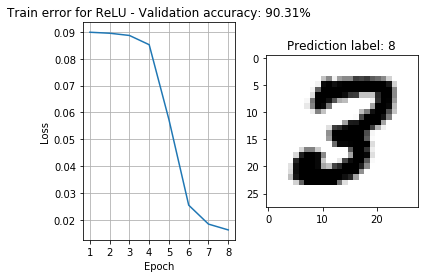

--------------------
Training model:  ELU
Training started - 8 epochs; batch size: 100; learning rate: 0.05


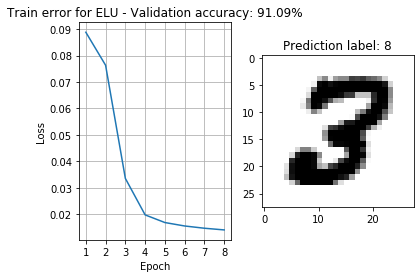

--------------------
Training model:  Sigmoid
Training started - 8 epochs; batch size: 100; learning rate: 0.05


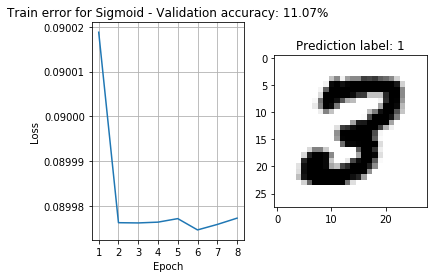

--------------------
Training model:  tanh
Training started - 8 epochs; batch size: 100; learning rate: 0.05


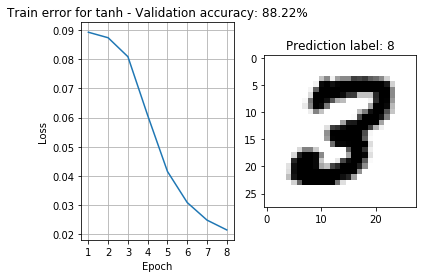

--------------------


In [103]:
print("Architecture: Conv2d block followed by a 300 neuron Linear layer")
print("-"*20)

epochs = 8
batch_size = 100
lr = 0.05

architecture = ["conv2d_32_3_1", "conv2d_32_3_1", "maxpool2d_3"]*1 + ["flatten"] + ["dense_300"]*1

activations = {
    "ReLU": torch.relu,
    "ELU": torch.nn.functional.elu,
    "Sigmoid": torch.sigmoid,
    "tanh": torch.tanh,
}

results = {}

for name, activation in activations.items():
    model = CustomModel(layers=architecture, with_softmax=True, hidden_activation=activation)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss = nn.MSELoss()
    print("Training model: ", name)
    train_errors = train(model, optimizer, loss, epochs, batch_size, verbose=0)
    val_acc = compute_accuracy(model, val_set)
    plt.subplot(121)
    plot_convergence(model_name=name, train_error=train_errors, val_acc=val_acc)
    plt.subplot(122)
    plot_image(model=model, val_set=val_set)
    plt.show()
    print("-"*20)

## Impact of the optimizer

### Influence of the algorithm

Chosen architecture: Conv block followed by 300 neurons LL
--------------------
Training model:  SGD
Training started - 8 epochs; batch size: 100; learning rate: 0.05
Epoch [1/8], Loss: 0.0899
Epoch [2/8], Loss: 0.0895
Epoch [3/8], Loss: 0.0888
Epoch [4/8], Loss: 0.0861
Epoch [5/8], Loss: 0.0641
Epoch [6/8], Loss: 0.0274
Epoch [7/8], Loss: 0.0188
Epoch [8/8], Loss: 0.0164


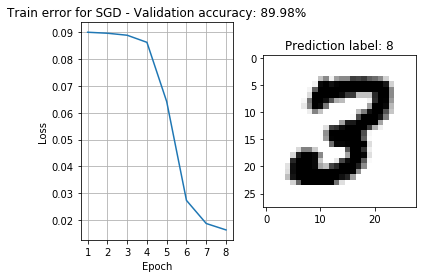

--------------------
Training model:  ASGD
Training started - 8 epochs; batch size: 100; learning rate: 0.05
Epoch [1/8], Loss: 0.0899
Epoch [2/8], Loss: 0.0894
Epoch [3/8], Loss: 0.0885
Epoch [4/8], Loss: 0.0851
Epoch [5/8], Loss: 0.0581
Epoch [6/8], Loss: 0.0263
Epoch [7/8], Loss: 0.0192
Epoch [8/8], Loss: 0.0169


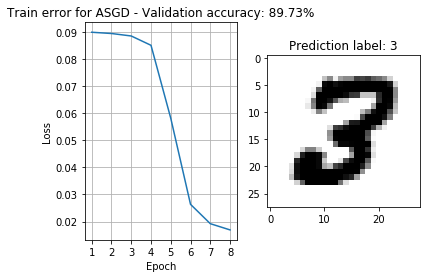

--------------------
Training model:  Adamax
Training started - 8 epochs; batch size: 100; learning rate: 0.01
Epoch [1/8], Loss: 0.0199
Epoch [2/8], Loss: 0.0087
Epoch [3/8], Loss: 0.0070
Epoch [4/8], Loss: 0.0058
Epoch [5/8], Loss: 0.0052
Epoch [6/8], Loss: 0.0047
Epoch [7/8], Loss: 0.0043
Epoch [8/8], Loss: 0.0040


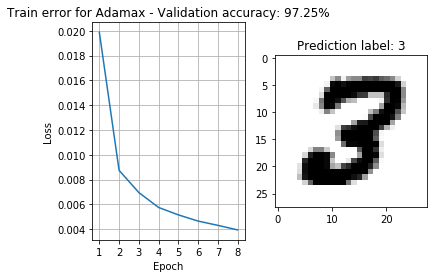

--------------------
Training model:  Adam
Training started - 8 epochs; batch size: 100; learning rate: 0.01
Epoch [1/8], Loss: 0.0117
Epoch [2/8], Loss: 0.0052
Epoch [3/8], Loss: 0.0045
Epoch [4/8], Loss: 0.0049
Epoch [5/8], Loss: 0.0058
Epoch [6/8], Loss: 0.0071
Epoch [7/8], Loss: 0.0117
Epoch [8/8], Loss: 0.0122


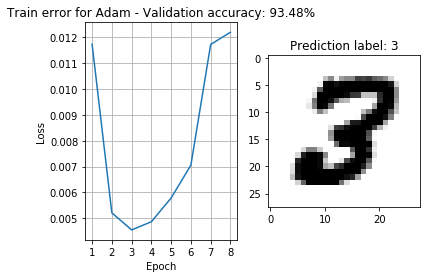

--------------------


In [118]:
print("Chosen architecture: Conv block followed by 300 neurons LL")
print("-"*20)

epochs = 8
batch_size = 100
lr = 0.01

architecture = ["conv2d_32_3_1", "conv2d_32_3_1", "maxpool2d_3"]*1 + ["flatten"] + ["dense_300"]*1

optimizers = {
    "SGD": (torch.optim.SGD, 0.05),
    "ASGD": (torch.optim.ASGD, 0.05),
    "Adamax": (torch.optim.Adamax, 0.01),
    "Adam": (torch.optim.Adam, 0.01),
}

results = {}

for name, (opt, lr) in optimizers.items():
    model = CustomModel(layers=architecture, with_softmax=True)
    optimizer = opt(model.parameters(), lr=lr)
    loss = nn.MSELoss()
    print("Training model: ", name)
    train_errors = train(model, optimizer, loss, epochs, batch_size, verbose=1)
    val_acc = compute_accuracy(model, val_set)
    plt.subplot(121)
    plot_convergence(model_name=name, train_error=train_errors, val_acc=val_acc)
    plt.subplot(122)
    plot_image(model=model, val_set=val_set)
    plt.show()
    print("-"*20)

### Influence of the batch size

Chosen architecture: Conv block followed by a 300 neurons LL
--------------------
Training model: batch size =  1000
Training started - 8 epochs; batch size: 1000; learning rate: 0.01


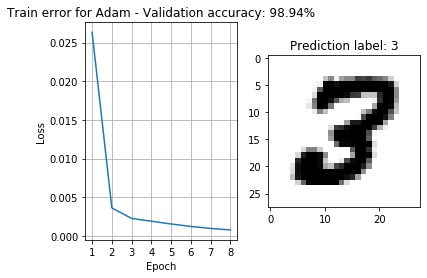

--------------------
Training model: batch size =  500
Training started - 8 epochs; batch size: 500; learning rate: 0.01


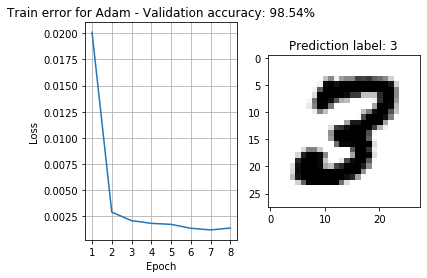

--------------------
Training model: batch size =  100
Training started - 8 epochs; batch size: 100; learning rate: 0.01


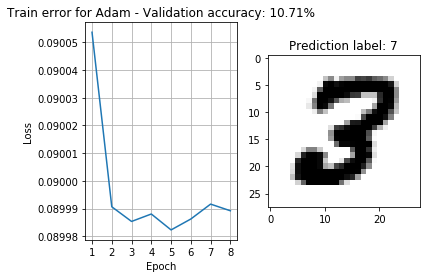

--------------------
Training model: batch size =  50
Training started - 8 epochs; batch size: 50; learning rate: 0.01


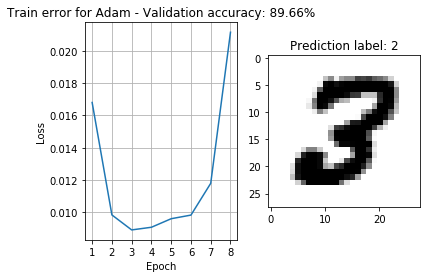

--------------------
Training model: batch size =  10
Training started - 8 epochs; batch size: 10; learning rate: 0.01


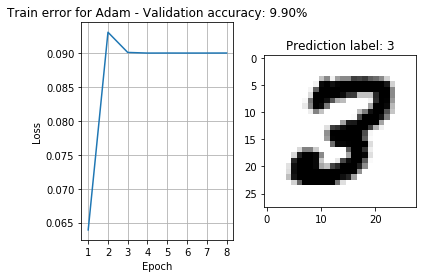

--------------------


In [121]:
print("Chosen architecture: Conv block followed by a 300 neurons LL")
print("-"*20)

epochs = 8
lr = 0.01

architecture = ["conv2d_32_3_1", "conv2d_32_3_1", "maxpool2d_3"]*1 + ["flatten"] + ["dense_300"]*1

opt = torch.optim.Adam

batch_sizes = [10, 50, 100, 500, 1000]

results = {}

for batch_size in reversed(batch_sizes):
    model = CustomModel(layers=architecture, with_softmax=True)
    optimizer = opt(model.parameters(), lr=lr)
    loss = nn.MSELoss()
    print("Training model: batch size = ", batch_size)
    train_errors = train(model, optimizer, loss, epochs, batch_size, verbose=0)
    val_acc = compute_accuracy(model, val_set)
    plt.subplot(121)
    plot_convergence(model_name=name, train_error=train_errors, val_acc=val_acc)
    plt.subplot(122)
    plot_image(model=model, val_set=val_set)
    plt.show()
    print("-"*20)

### Influence of the Learning Rate

Chosen architecture: Conv block followed by a 300 neurons LL
--------------------
Training model:  learning rate = 0.001
Training started - 8 epochs; batch size: 100; learning rate: 0.001


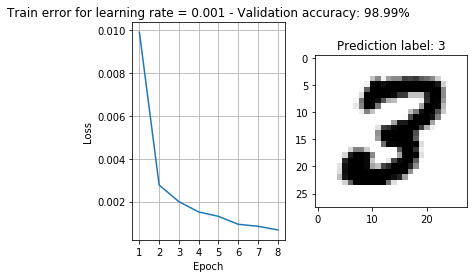

--------------------
Training model:  learning rate = 0.01
Training started - 8 epochs; batch size: 100; learning rate: 0.01


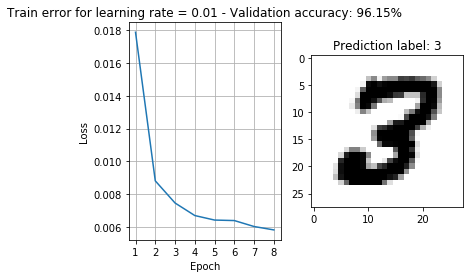

--------------------
Training model:  learning rate = 0.1
Training started - 8 epochs; batch size: 100; learning rate: 0.1


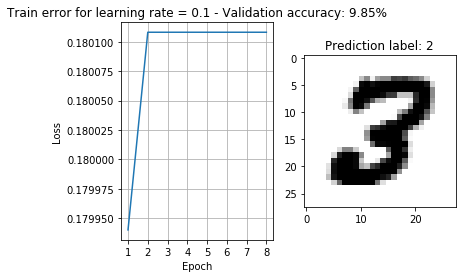

--------------------
Training model:  learning rate = 1
Training started - 8 epochs; batch size: 100; learning rate: 1


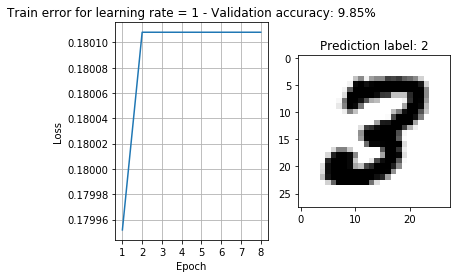

--------------------
Training model:  learning rate = 10
Training started - 8 epochs; batch size: 100; learning rate: 10


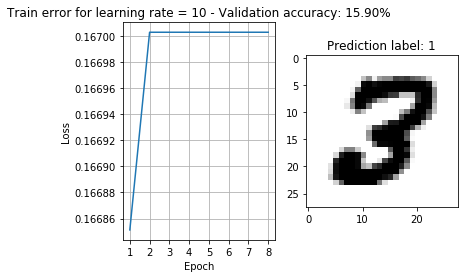

--------------------


In [123]:
print("Chosen architecture: Conv block followed by a 300 neurons LL")
print("-"*20)

epochs = 8
batch_size = 100

architecture = ["conv2d_32_3_1", "conv2d_32_3_1", "maxpool2d_3"]*1 + ["flatten"] + ["dense_300"]*1

opt = torch.optim.Adam

learning_rates = {
    "learning rate = 0.001": 0.001,
    "learning rate = 0.01": 0.01,
    "learning rate = 0.1": 0.1,
    "learning rate = 1": 1,
    "learning rate = 10": 10,
}

results = {}

for name, lr in learning_rates.items():
    model = CustomModel(layers=architecture, with_softmax=True)
    optimizer = opt(model.parameters(), lr=lr)
    loss = nn.MSELoss()
    print("Training model: ", name)
    train_errors = train(model, optimizer, loss, epochs, batch_size, verbose=0)
    val_acc = compute_accuracy(model, val_set)
    plt.subplot(121)
    plot_convergence(model_name=name, train_error=train_errors, val_acc=val_acc)
    plt.subplot(122)
    plot_image(model=model, val_set=val_set)
    plt.show()
    print("-"*20)

## Influence of the loss function

Chosen architecture: Conv block followed by a 300 neurons LL
--------------------
Training model:  <class 'torch.nn.modules.loss.CrossEntropyLoss'>
Training started - 8 epochs; batch size: 100; learning rate: 0.01


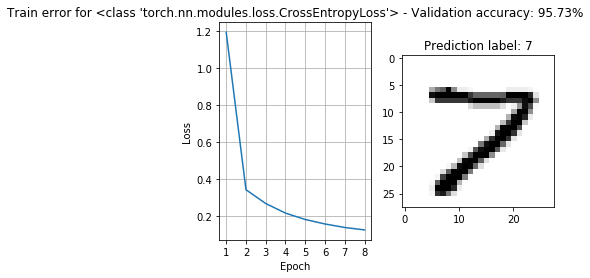

--------------------
Training model:  <class 'torch.nn.modules.loss.MSELoss'>
Training started - 8 epochs; batch size: 100; learning rate: 0.01


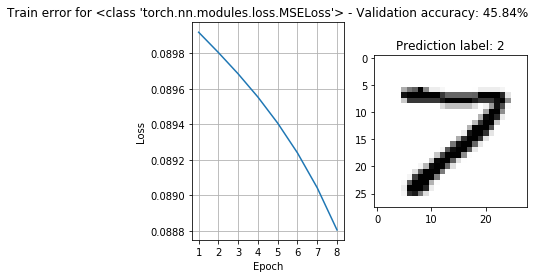

--------------------


In [9]:
print("Chosen architecture: Conv block followed by a 300 neurons LL")
print("-"*20)

epochs = 8
batch_size = 100
lr=0.01

architecture = ["conv2d_32_3_1", "conv2d_32_3_1", "maxpool2d_3"]*1 + ["flatten"] + ["dense_300"]*1

opt = torch.optim.SGD

losses = [(torch.nn.CrossEntropyLoss, False), (torch.nn.MSELoss, True)]

results = {}

for Loss, with_softmax in losses:
    model = CustomModel(layers=architecture, with_softmax=with_softmax)
    optimizer = opt(model.parameters(), lr=lr)
    loss = Loss()
    print("Training model: ", Loss)
    train_errors = train(model, optimizer, loss, epochs, batch_size, verbose=0)
    val_acc = compute_accuracy(model, val_set)
    plt.subplot(121)
    plot_convergence(model_name=Loss, train_error=train_errors, val_acc=val_acc)
    plt.subplot(122)
    plot_image(model=model, val_set=val_set)
    plt.show()
    print("-"*20)